In [143]:
from core.semcor_bert_pipeline import *
import pandas as pd

In [144]:
df = pd.read_csv('../data/rabagliati_2013_stimuli.csv')
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenize_ctx = lambda t: tokenizer.tokenize(t)
df['tokenized_dis_ctx'] = df['dis_ctx'].apply(tokenize_ctx)

In [145]:
model = initialize_model()

In [185]:
df = df[~df['target'].isin(['moose', 'mousse'])] #BERT tokenization issues

In [186]:
bert_data = []
for i in np.arange(0, len(df.index) - 4, 4):
    type_stimuli = df.iloc[i:i + 4]
    for sent_ctx in ['curr', 'prev']:
        curr_prev_ctx = type_stimuli[type_stimuli['sentence_ctx'] == sent_ctx]
        for row in curr_prev_ctx.iterrows():
            row = row[1]
            s1, s2, target_token = row['s1'], row['s2'], row['target']
            indexed_tokens, tokenized_text = preprocess(s1, target_token, s2 = s2)
            target_activations, attns = get_model_output(indexed_tokens, model)
            attn_dict = process_raw_attentions([attns], [tokenized_text])[0]
            target_embeddings = sum_layers(target_activations, -4)
            bert_data.append({"attns": attn_dict, "target_embed": target_embeddings, "target_name": target_token,
                             "tokenized_sents": tokenized_text[0], "tokenized_dis": row['tokenized_dis_ctx'],
                             "sent_ctx": sent_ctx})

In [187]:
def find_sub_list(sl,l):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1


In [329]:
prev_attn = []
curr_attn = []
prev_layers = []
curr_layers = []
failures = []
prev_attn_ranks = []
curr_attn_ranks = []
prev_rank_layers = []
curr_rank_layers = []
for d in bert_data:
    lex_indices = [i for i in range(len(d['tokenized_sents'])) if d['tokenized_sents'][i] not in ["[CLS]", "[SEP]", ".", ","]]
    lex_tokens = np.array(d['tokenized_sents'])[lex_indices]
    dis_indices = find_sub_list(d['tokenized_dis'], lex_tokens.tolist())
    if dis_indices is not None:
        dis_start = dis_indices[0]
        dis_end = dis_indices[1] + 1
        target_indices = np.arange(dis_start, dis_end)
        for layer in d['attns']:
            a = d['attns'][layer][lex_indices]
            summed_attns = np.sum(a[dis_start:dis_end])
            attn_ranks = [i / len(lex_tokens) for i in np.arange(len(a)) if np.argsort(a)[i] in target_indices]
            if d['sent_ctx'] == 'prev':
                prev_attn.append(summed_attns)
                prev_attn_ranks += attn_ranks
                prev_rank_layers += [layer] * len(attn_ranks)
                prev_layers.append(layer)
            if d['sent_ctx'] == 'curr':
                curr_attn.append(summed_attns)
                curr_attn_ranks += attn_ranks
                curr_rank_layers += [layer] * len(attn_ranks)
                curr_layers.append(layer)
    else:
        failures.append((d['tokenized_dis'], d['tokenized_sents']))

Text(0.5, 1, 'Normalized Ranks of Disambiguating Tokens')

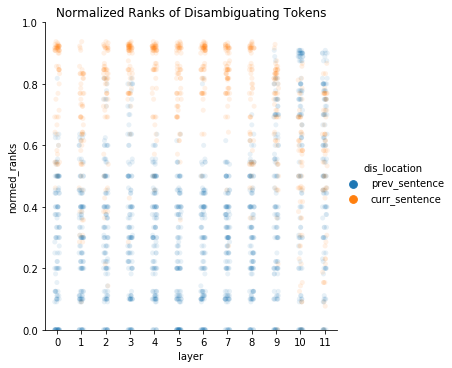

In [330]:
results = pd.DataFrame({"layer": prev_rank_layers + curr_rank_layers, "normed_ranks": prev_attn_ranks + curr_attn_ranks,
              "dis_location": (["prev_sentence"] * len(prev_rank_layers)) + (['curr_sentence'] * len(curr_rank_layers))})
sns.catplot(x = 'layer', y = 'normed_ranks', hue = 'dis_location', data = results, alpha = 0.1)
plt.ylim(0, 1)
plt.title("Normalized Ranks of Disambiguating Tokens")

In [ ]:
attn_ranks = pd.DataFrame({"layer": prev_layers + curr_layers, "attn": prev_attn + curr_attn,
              "dis_location": (["prev_sentence"] * len(prev_attn)) + (['curr_sentence'] * len(curr_attn))})
sns.catplot(x = attn_ranks)

In [240]:
curr_prev_sent = []
for d in bert_data:
    sep_index = d['tokenized_sents'].index("[SEP]")
    for l in d['attns']:
        sum_prev = np.sum(d['attns'][l][1:sep_index - 1])
        sum_curr = np.sum(d['attns'][l][sep_index + 1:-2])
        #sum_prev = np.sum(d['attns'][l][:sep_index + 1])
        #sum_curr = np.sum(d['attns'][l][sep_index + 1:])
        curr_prev_sent.append({"layer": l, 'prior_attn': sum_prev,
                               'target_attn': sum_curr, "sent_ctx": d['sent_ctx']})
        

In [241]:
curr_prev_sent = pd.DataFrame(curr_prev_sent)

curr_prev_sent.groupby('sent_ctx').agg('mean').drop('layer', axis = 1)

,prior_attn,target_attn
sent_ctx,,
curr,0.055747,0.287515
prev,0.081473,0.195250


In [242]:
curr_prev_sent

,layer,prior_attn,target_attn,sent_ctx
0,0,0.068779,0.627686,curr
1,1,0.038878,0.345148,curr
2,2,0.032662,0.374662,curr
3,3,0.028078,0.322214,curr
4,4,0.016635,0.174049,curr
...,...,...,...,...
1003,7,0.020762,0.277704,prev
1004,8,0.081311,0.163851,prev
1005,9,0.157462,0.168981,prev
1006,10,0.183902,0.126041,prev


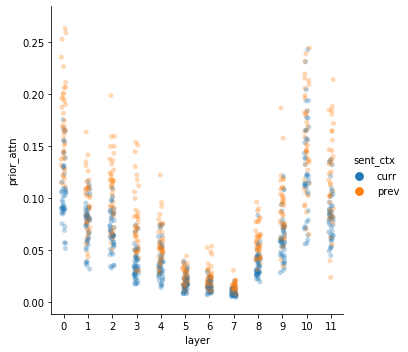

In [267]:
sns.catplot(x = 'layer', y = 'prior_attn', hue = 'sent_ctx', data = curr_prev_sent, alpha = 0.3)

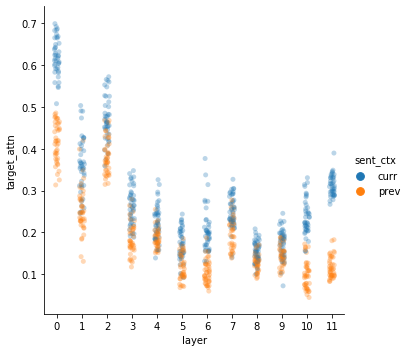

In [266]:
sns.catplot(x = 'layer', y = 'target_attn', hue = 'sent_ctx', data = curr_prev_sent, alpha = 0.3)

In [ ]:
curr_prev_sent = []
for d in bert_data:
    sep_index = d['tokenized_sents'].index("[SEP]")
    for l in d['attns']:
        sum_prev = np.sum(d['attns'][l][1:sep_index - 1])
        sum_curr = np.sum(d['attns'][l][sep_index + 1:-2])
        curr_prev_sent.append({"layer": l, 'prior_attn': sum_prev,
                               'target_attn': sum_curr, "sent_ctx": d['sent_ctx']})
        

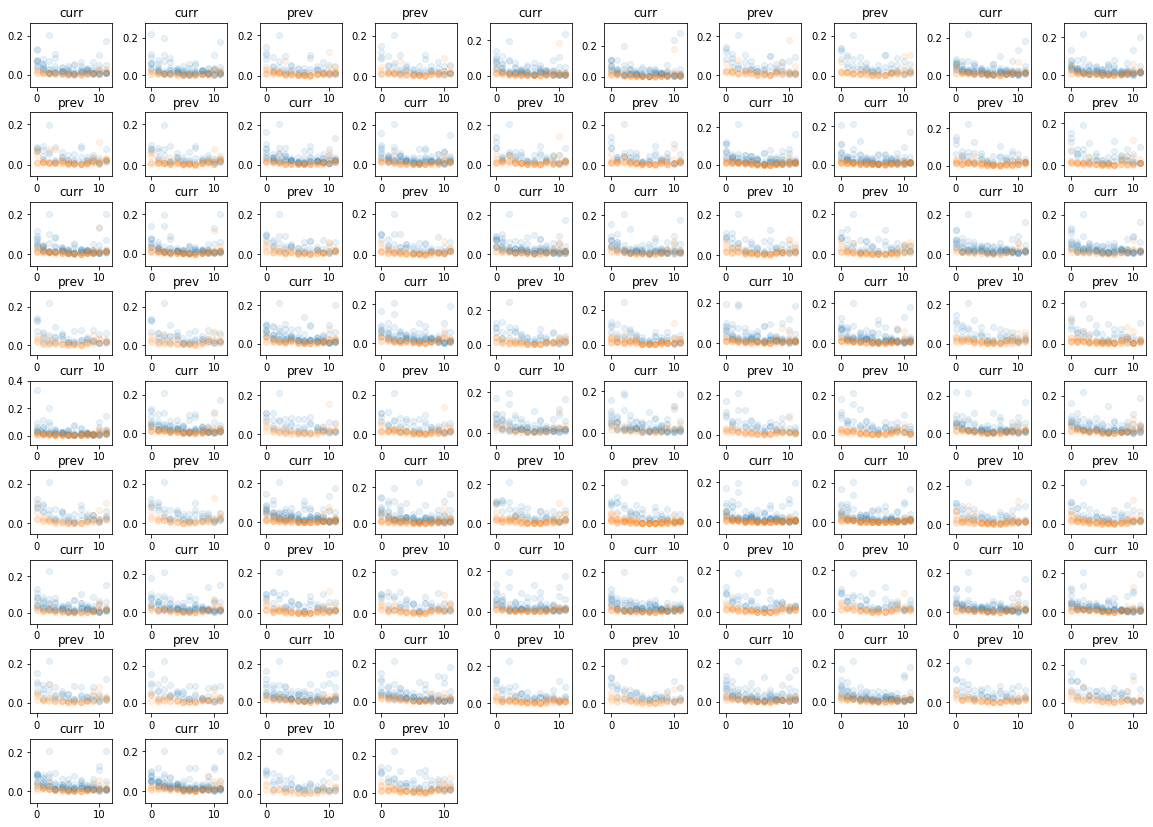

In [265]:
fig = plt.figure(figsize = (20, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, len(bert_data) + 1):
    ax = fig.add_subplot(10, 10, i)
    sent_index = i - 1
    data = bert_data[sent_index]
    sep_index = data['tokenized_sents'].index("[SEP]")
    prev_layers = []
    curr_layers = []
    prev_attn = []
    curr_attn = []
    for l in data['attns']:
        prev_sent = data['attns'][l][1:sep_index - 1].tolist()
        tok_sent = data['attns'][l][sep_index + 1:-2].tolist()
        prev_attn += prev_sent
        curr_attn += tok_sent
        prev_layers += [l] * len(prev_sent)
        curr_layers += [l] * len(tok_sent)
    ax.scatter(curr_layers, curr_attn, alpha = 0.1)
    ax.scatter(prev_layers, prev_attn, alpha = 0.1)
    ax.set_title(data['sent_ctx'])
